Instalar paquetes necesarios

In [ ]:
! pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 14.1 MB/s eta 0:00:00


In [ ]:
# Leer Archivos Drive
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# =====================
# Librerías estándar
# =====================
import sys
import warnings
from typing import Union, Optional
from datetime import datetime

# =====================
# Ciencia de datos
# =====================
import pandas as pd
import numpy as np

# =====================
# Visualización
# =====================
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# Series de tiempo y estadística
# =====================
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.unitroot import PhillipsPerron
from scipy import stats
from scipy.stats import norm

# =====================
# Configuración
# =====================
warnings.filterwarnings("ignore")

# =====================
# Importar funciones auxiliares desde Google Drive
# =====================
sys.path.append('/content/drive/MyDrive/Datos_EESS')
print(f"sys.path after adding: {sys.path}")  # Verificación
from funciones_auxiliares import *

import numpy as np

sys.path after adding: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Datos_EESS', '/content/drive/MyDrive/Datos_EESS']


In [ ]:

# Leer CSV
try:
    merged_df_completo = pd.read_csv('/content/drive/MyDrive/Datos_EESS/datos_serie_anon.csv')
    print("CSV cargado correctamente!")
    #display(df.head()) # Display the first 5 rows
except FileNotFoundError:
    print("Error: Verifique que el path sea correcto.")
except Exception as e:
    print(f"Ocurrio un error: {e}")

CSV cargado correctamente!


### RESUMEN EJECUTIVO

El estudio tiene por objetivo modelar y pronosticar las ventas diarias de tres combustibles en una estación de servicio, con un horizonte mínimo de siete días, a fin de respaldar la planificación logística. Se adoptarán las metodologías presentadas en la asignatura para el analisis de las mismas. La selección de modelos se sustentará en pruebas estadísticas y diagnósticos gráficos para caracterizar tendencia, estacionalidad semanal y efectos de calendario. La capacidad predictiva se evaluará mediante métricas de precisión —por ejemplo, MAE, RMSE y MAPE— y mediante esquemas de validación temporal. La contribución principal reside en la aplicación de técnicas consolidadas de pronóstico a un problema operativo del sector de combustibles, con impacto en la reducción de quiebres de stock, el dimensionamiento de pedidos y la programación de reabastecimientos.

### INTRODUCCION

El presente trabajo aborda la modelación y el pronóstico de las ventas diarias de tres combustibles líquidos en una estación de servicio: nafta grado 95, nafta grado 97 y diésel de ultra bajo azufre. El propósito central consiste en generar proyecciones con un horizonte mínimo de siete días, a fin de respaldar la planificación logística, el dimensionamiento de pedidos y la reducción de quiebres de stock.

La base de datos proviene de registros operativos de ventas en surtidor. El conjunto incluye, como elementos principales, la fecha de operación y los volúmenes diarios despachados por producto. Para el tratamiento como series temporales, la fecha se establece como índice cronológico con frecuencia diaria; en el análisis se consideran patrones de estacionalidad semanal, efectos de calendario (fines de semana, feriados) y posibles cambios de nivel asociados a eventos operativos.

Con el fin de explicar y anticipar la dinámica de la demanda, el estudio adopta enfoques estándar de series temporales univariadas (ARIMA/SARIMA) y, cuando corresponde, su extensión con regresores de calendario. La identificación del modelo se apoya en pruebas estadísticas y diagnósticos gráficos orientados a determinar ordenes autorregresivos y de diferenciación, así como la presencia de estacionalidad. La evaluación de la capacidad predictiva se realiza mediante métricas de precisión (MAE, RMSE y MAPE) y esquemas de validación temporal.



### EDA

In [ ]:
# Ensure 'fecha' is a datetime object and set as index
merged_df_completo['fecha'] = pd.to_datetime(merged_df_completo['fecha'])
merged_df_completo = merged_df_completo.set_index('fecha')

# Ordenar el dataframe por fecha (ahora el index)
merged_df_completo = merged_df_completo.sort_index()

# Mostrar las primeras filas del dataframe combinado
print("Dataframe combinado con fechas completas:")
display(merged_df_completo.head())

# Mostrar información sobre el dataframe combinado
merged_df_completo.info()

Dataframe combinado con fechas completas:


,volumen_DSP,volumen_NFP,volumen_NFC
fecha,,,
2022-04-01,8250.661415,2812.930519,9617.223206
2022-04-02,6217.523570,2646.149141,8787.202670
2022-04-03,6930.748854,1241.374704,9359.098394
2022-04-04,5653.462986,2040.678695,10815.788281
2022-04-05,8928.674663,2990.599222,10397.908453


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1102 entries, 2022-04-01 to 2025-04-06
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   volumen_DSP  1102 non-null   float64
 1   volumen_NFP  1102 non-null   float64
 2   volumen_NFC  1102 non-null   float64
dtypes: float64(3)
memory usage: 34.4 KB


In [ ]:
merged_df_filtrado = merged_df_completo.copy()

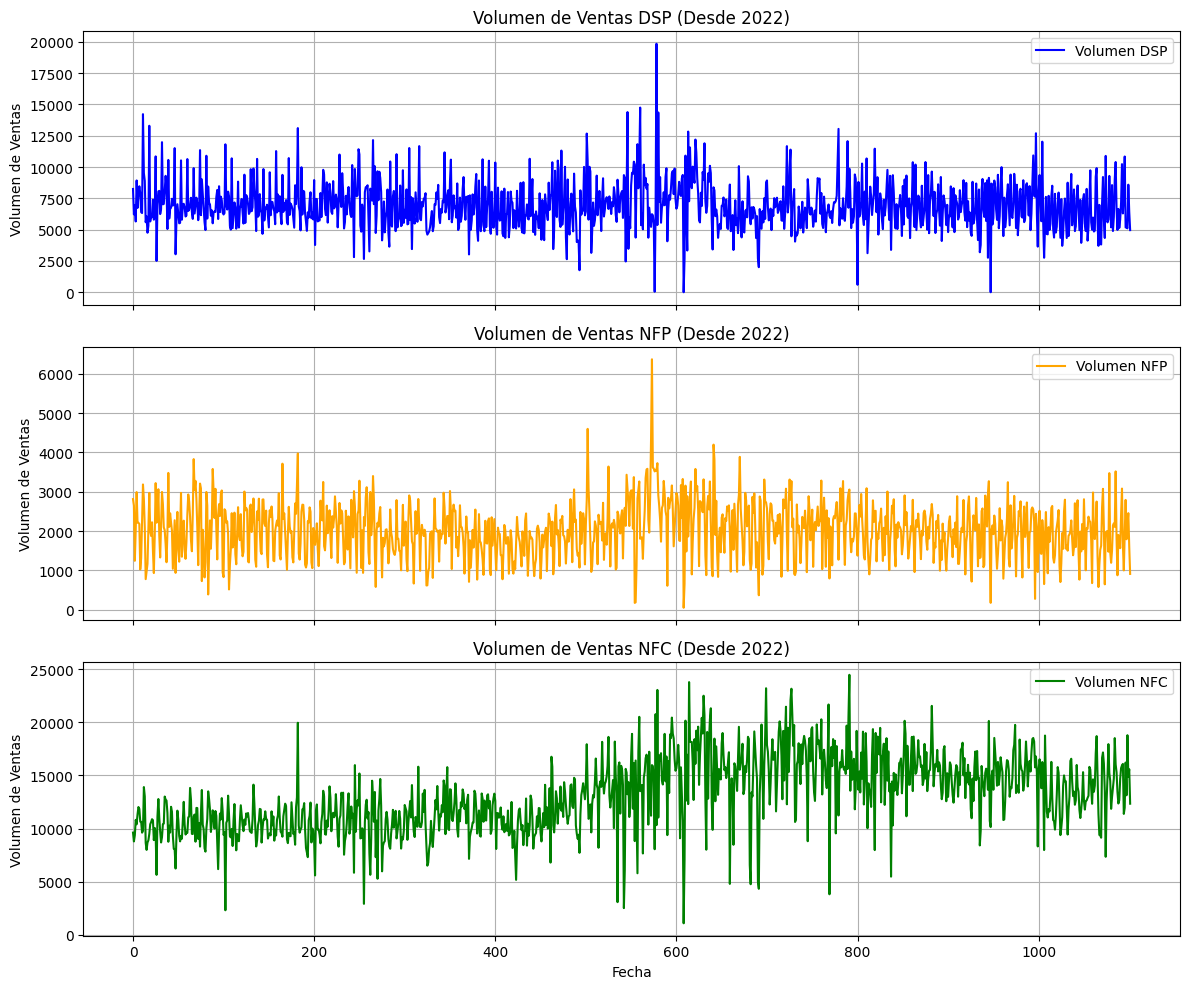

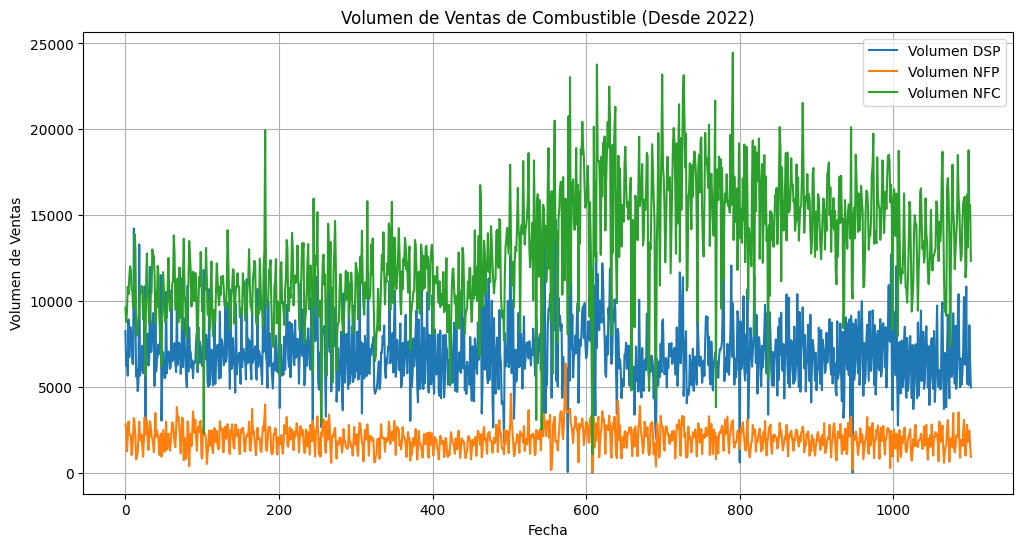

In [ ]:
# Grafico de series por separado y en conjunto
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

axes[0].plot(merged_df_filtrado.index, merged_df_filtrado['volumen_DSP'], label='Volumen DSP', color='blue')
axes[0].set_title('Volumen de Ventas DSP (Desde 2022)')
axes[0].set_ylabel('Volumen de Ventas')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(merged_df_filtrado.index, merged_df_filtrado['volumen_NFP'], label='Volumen NFP', color='orange')
axes[1].set_title('Volumen de Ventas NFP (Desde 2022)')
axes[1].set_ylabel('Volumen de Ventas')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(merged_df_filtrado.index, merged_df_filtrado['volumen_NFC'], label='Volumen NFC', color='green')
axes[2].set_title('Volumen de Ventas NFC (Desde 2022)')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Volumen de Ventas')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Plot all three filtered series together
plt.figure(figsize=(12, 6))
plt.plot(merged_df_filtrado.index, merged_df_filtrado['volumen_DSP'], label='Volumen DSP')
plt.plot(merged_df_filtrado.index, merged_df_filtrado['volumen_NFP'], label='Volumen NFP')
plt.plot(merged_df_filtrado.index, merged_df_filtrado['volumen_NFC'], label='Volumen NFC')
plt.title('Volumen de Ventas de Combustible (Desde 2022)')
plt.xlabel('Fecha')
plt.ylabel('Volumen de Ventas')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# merged_df_completo = merged_df_filtrado.copy()

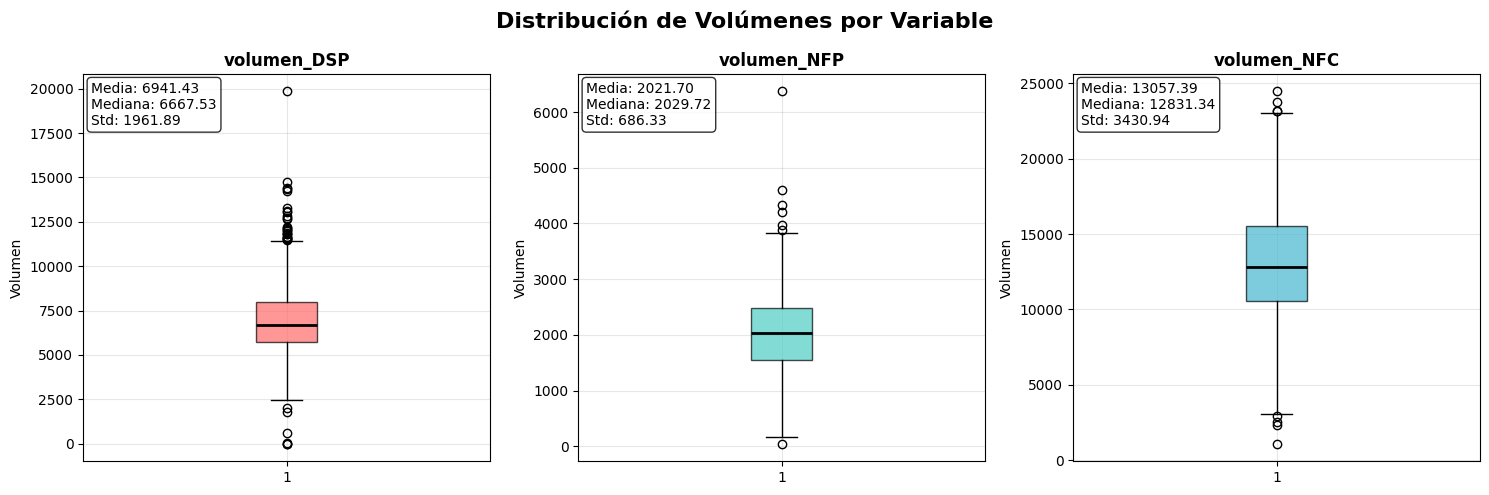

In [ ]:
# Configurar estilo de los gráficos
plt.style.use('default')
sns.set_palette("husl")

# --- BOXPLOTS INDIVIDUALES ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribución de Volúmenes por Variable', fontsize=16, fontweight='bold')

# Boxplot para cada variable
variables = ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (var, color) in enumerate(zip(variables, colores)):
    axes[i].boxplot(merged_df_completo[var].dropna(),
                   patch_artist=True,
                   boxprops=dict(facecolor=color, alpha=0.7),
                   medianprops=dict(color='black', linewidth=2))
    axes[i].set_title(f'{var}', fontweight='bold')
    axes[i].set_ylabel('Volumen')
    axes[i].grid(True, alpha=0.3)

    # Añadir estadísticas básicas como texto
    data = merged_df_completo[var].dropna()
    stats_text = f'Media: {data.mean():.2f}\nMediana: {data.median():.2f}\nStd: {data.std():.2f}'
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()



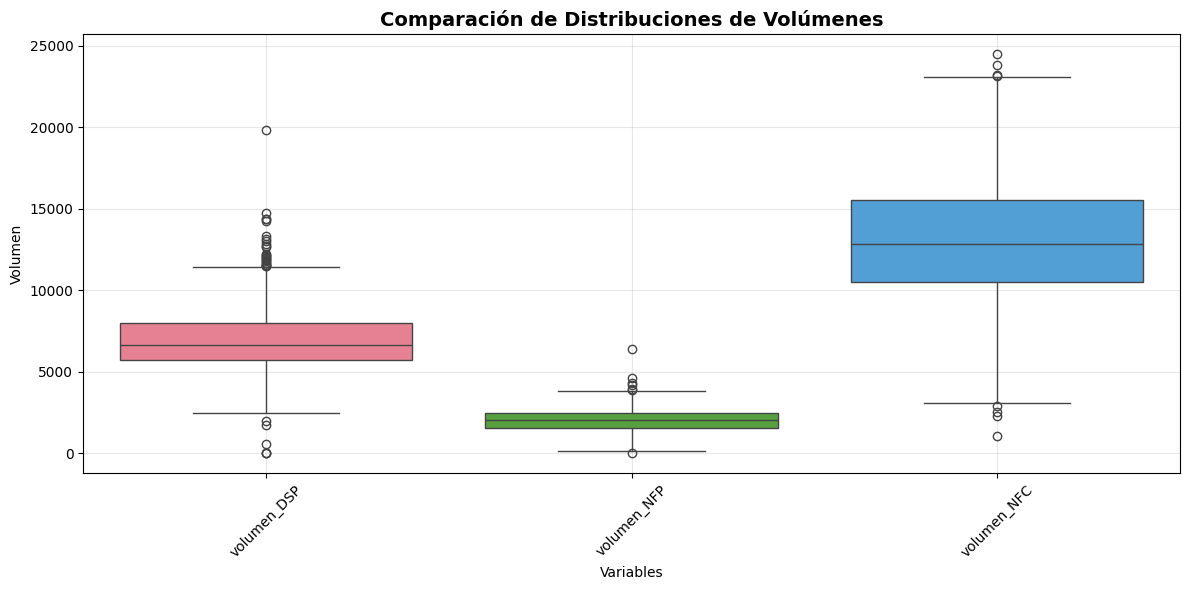

In [ ]:
# --- BOXPLOT CONJUNTO ---
plt.figure(figsize=(12, 6))

# Preparar datos en formato largo para seaborn
df_melted = merged_df_completo.reset_index().melt(
    id_vars=['fecha'],
    value_vars=['volumen_DSP', 'volumen_NFP', 'volumen_NFC'],
    var_name='Variable',
    value_name='Volumen'
)

# Crear boxplot conjunto
sns.boxplot(data=df_melted, x='Variable', y='Volumen', palette='husl')
plt.title('Comparación de Distribuciones de Volúmenes', fontsize=14, fontweight='bold')
plt.ylabel('Volumen')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- TABLA DE SUMMARY DETALLADA ---
print("="*80)
print("TABLA DE SUMMARY ESTADÍSTICO")
print("="*80)

# Crear tabla de summary personalizada
summary_stats = []

for col in ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']:
    data = merged_df_completo[col].dropna()

    stats = {
        'Variable': col,
        'Count': len(data),
        'Missing': merged_df_completo[col].isna().sum(),
        'Mean': data.mean(),
        'Median': data.median(),
        'Std': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Q1': data.quantile(0.25),
        'Q3': data.quantile(0.75),
        'IQR': data.quantile(0.75) - data.quantile(0.25),
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    }
    summary_stats.append(stats)

# Convertir a DataFrame para mejor visualización
summary_df = pd.DataFrame(summary_stats)

# Formatear números para mejor legibilidad
numeric_cols = ['Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3', 'IQR']
for col in numeric_cols:
    summary_df[col] = summary_df[col].round(2)

summary_df['Skewness'] = summary_df['Skewness'].round(3)
summary_df['Kurtosis'] = summary_df['Kurtosis'].round(3)

print(summary_df.to_string(index=False))

TABLA DE SUMMARY ESTADÍSTICO
   Variable  Count  Missing     Mean   Median     Std     Min      Max       Q1       Q3     IQR  Skewness  Kurtosis
volumen_DSP   1102        0  6941.43  6667.53 1961.89    0.00 19848.62  5704.93  8000.68 2295.75     0.721     2.572
volumen_NFP   1102        0  2021.70  2029.72  686.33   45.70  6371.38  1549.33  2477.64  928.30     0.291     1.282
volumen_NFC   1102        0 13057.39 12831.34 3430.94 1084.59 24462.23 10525.34 15552.08 5026.73     0.162    -0.034


In [ ]:
# --- SUMMARY DE PANDAS BÁSICO ---
print("\n" + "="*80)
print("SUMMARY BÁSICO DE PANDAS")
print("="*80)
print(merged_df_completo[['volumen_DSP', 'volumen_NFP', 'volumen_NFC']].describe())


SUMMARY BÁSICO DE PANDAS
        volumen_DSP  volumen_NFP   volumen_NFC
count   1102.000000  1102.000000   1102.000000
mean    6941.425034  2021.700047  13057.386822
std     1961.894353   686.326238   3430.938834
min        0.000000    45.700942   1084.591409
25%     5704.929091  1549.332260  10525.343965
50%     6667.529519  2029.722790  12831.337619
75%     8000.680501  2477.635246  15552.078411
max    19848.621375  6371.377926  24462.227885


In [ ]:
# --- INFORMACIÓN ADICIONAL ---
print("\n" + "="*80)
print("INFORMACIÓN ADICIONAL")
print("="*80)

print(f"Período de datos: {merged_df_completo.index.min().strftime('%Y-%m-%d')} a {merged_df_completo.index.max().strftime('%Y-%m-%d')}")
print(f"Total de días: {len(merged_df_completo)}")
print(f"Días con datos completos: {merged_df_completo.dropna().shape[0]}")

# Matriz de correlación
print("\nMATRIZ DE CORRELACIÓN:")
correlation_matrix = merged_df_completo[['volumen_DSP', 'volumen_NFP', 'volumen_NFC']].corr()
print(correlation_matrix.round(3))

# --- DETECCIÓN DE OUTLIERS ---
print("\n" + "="*80)
print("DETECCIÓN DE OUTLIERS (Método IQR)")
print("="*80)


INFORMACIÓN ADICIONAL
Período de datos: 2022-04-01 a 2025-04-06
Total de días: 1102
Días con datos completos: 1102

MATRIZ DE CORRELACIÓN:
             volumen_DSP  volumen_NFP  volumen_NFC
volumen_DSP        1.000        0.447        0.207
volumen_NFP        0.447        1.000        0.342
volumen_NFC        0.207        0.342        1.000

DETECCIÓN DE OUTLIERS (Método IQR)


In [ ]:
# --- ANÁlISIS DE OUTLIERS ---
for col in ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']:
    data = merged_df_completo[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]

    print(f"\n{col}:")
    print(f"  Límite inferior: {lower_bound:.2f}")
    print(f"  Límite superior: {upper_bound:.2f}")
    print(f"  Número de outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"  Outliers más extremos: {outliers.nlargest(3).values} (mayores), {outliers.nsmallest(3).values} (menores)")


volumen_DSP:
  Límite inferior: 2261.30
  Límite superior: 11444.31
  Número de outliers: 31 (2.8%)
  Outliers más extremos: [19848.62137542 14751.85748569 14391.89721272] (mayores), [ 0.          0.         40.51145581] (menores)

volumen_NFP:
  Límite inferior: 156.88
  Límite superior: 3870.09
  Número de outliers: 7 (0.6%)
  Outliers más extremos: [6371.37792604 4600.33356959 4339.03397654] (mayores), [  45.7009418  3887.45037276 3973.78835232] (menores)

volumen_NFC:
  Límite inferior: 2985.24
  Límite superior: 23092.18
  Número de outliers: 8 (0.7%)
  Outliers más extremos: [24462.2278849  23775.92332117 23197.3858335 ] (mayores), [1084.5914087  2310.6811297  2513.90466356] (menores)


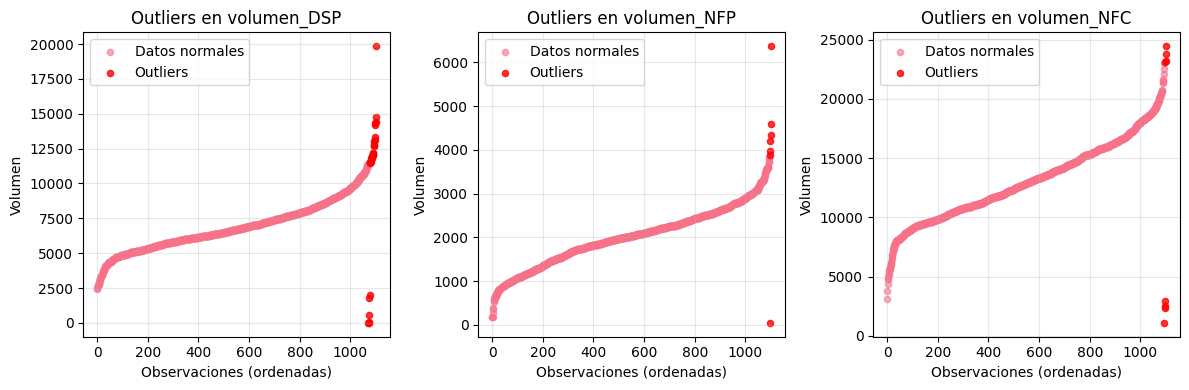

In [ ]:
# --- GRÁFICO DE OUTLIERS ---
plt.figure(figsize=(12, 4))

for i, col in enumerate(['volumen_DSP', 'volumen_NFP', 'volumen_NFC'], 1):
    plt.subplot(1, 3, i)
    data = merged_df_completo[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Scatter plot con outliers destacados
    normal_data = data[(data >= lower_bound) & (data <= upper_bound)]
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    plt.scatter(range(len(normal_data)), normal_data.sort_values(),
               alpha=0.6, s=20, label='Datos normales')
    if len(outliers) > 0:
        plt.scatter(range(len(normal_data), len(data)), outliers.sort_values(),
                   color='red', alpha=0.8, s=20, label='Outliers')

    plt.title(f'Outliers en {col}')
    plt.ylabel('Volumen')
    plt.xlabel('Observaciones (ordenadas)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

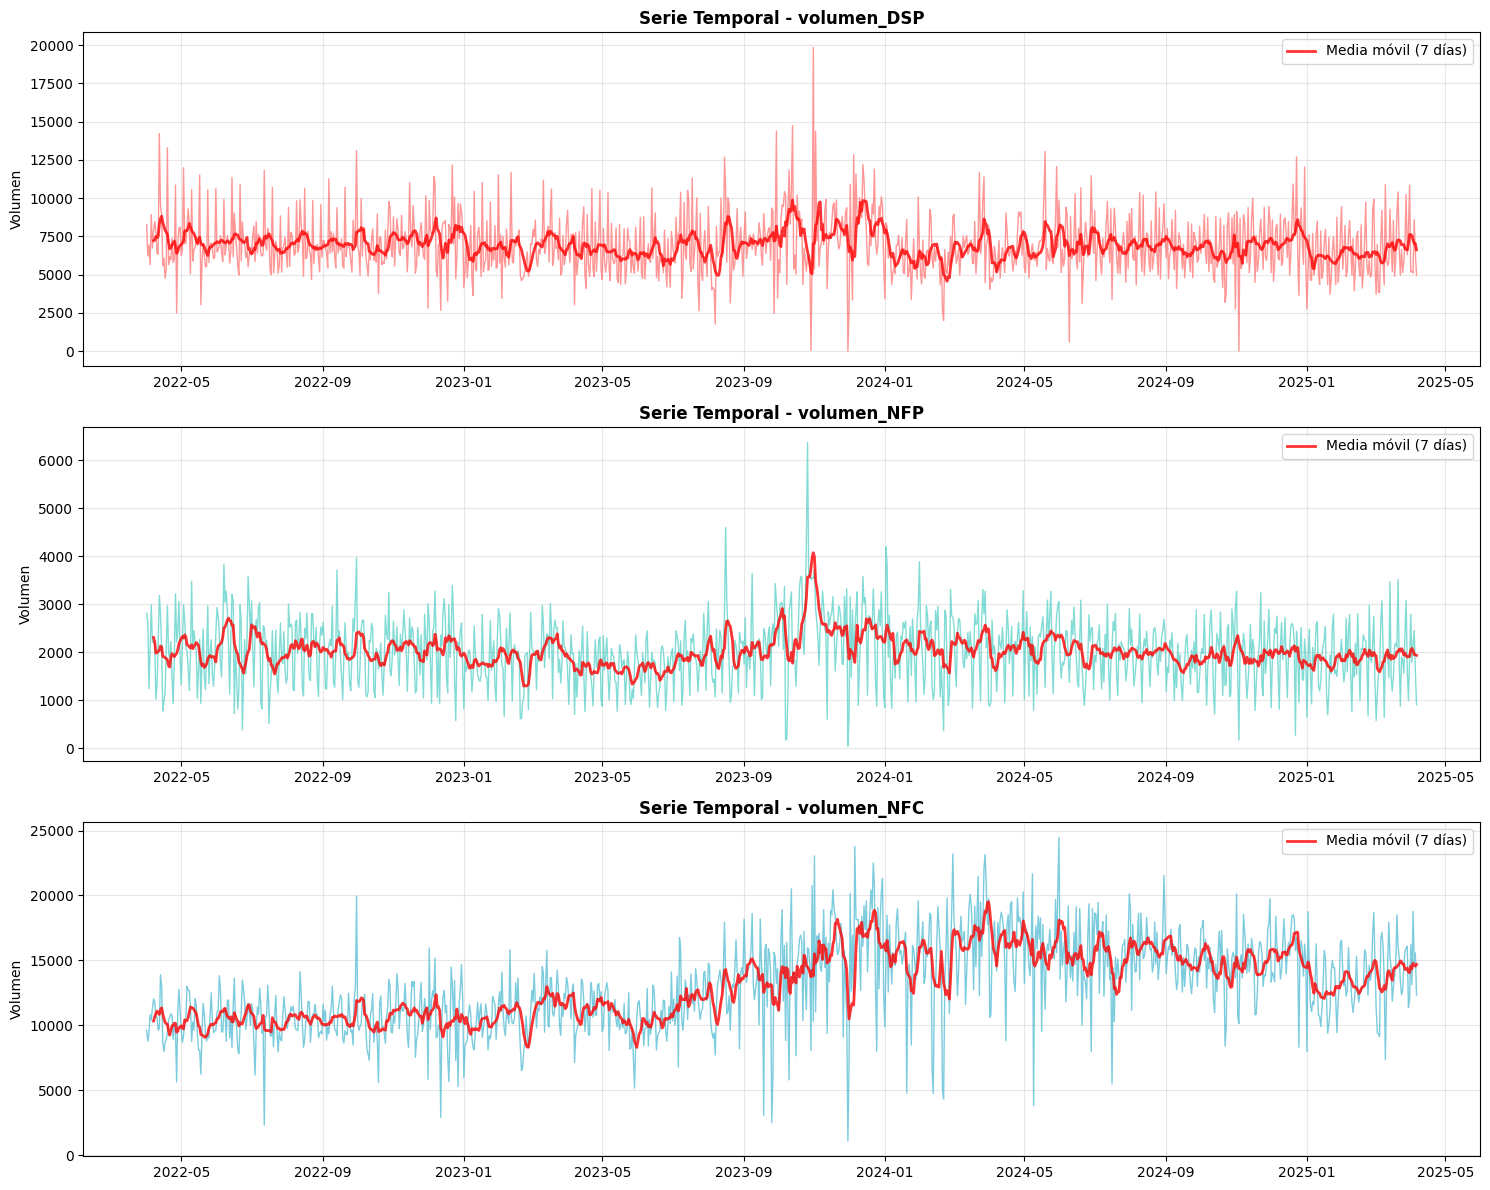

In [ ]:
# Configurar estilo
plt.style.use('default')
sns.set_palette("husl")

# Gráfico de series temporales
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
variables = ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (var, color) in enumerate(zip(variables, colors)):
    axes[i].plot(merged_df_completo.index, merged_df_completo[var],
                color=color, alpha=0.7, linewidth=1)
    axes[i].set_title(f'Serie Temporal - {var}', fontweight='bold')
    axes[i].set_ylabel('Volumen')
    axes[i].grid(True, alpha=0.3)

    # Agregar media móvil
    rolling_mean = merged_df_completo[var].rolling(window=7).mean()
    axes[i].plot(merged_df_completo.index, rolling_mean,
                color='red', linewidth=2, alpha=0.8, label='Media móvil (7 días)')
    axes[i].legend()

plt.tight_layout()
plt.show()



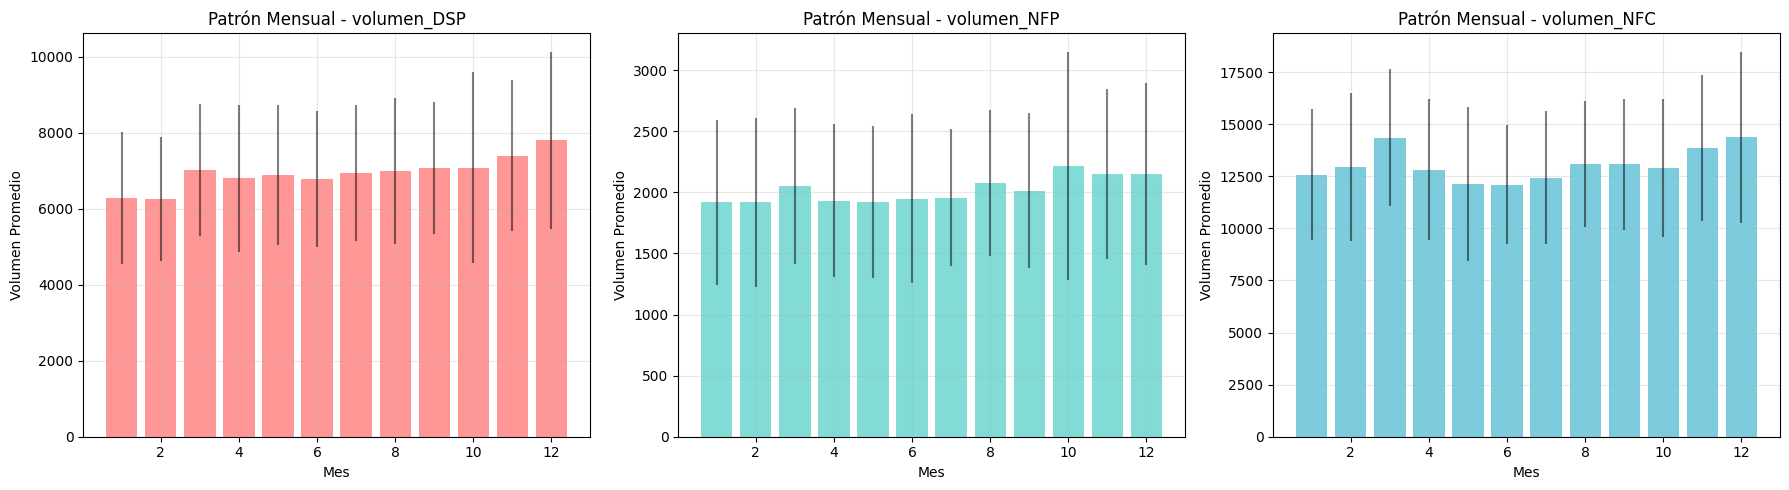

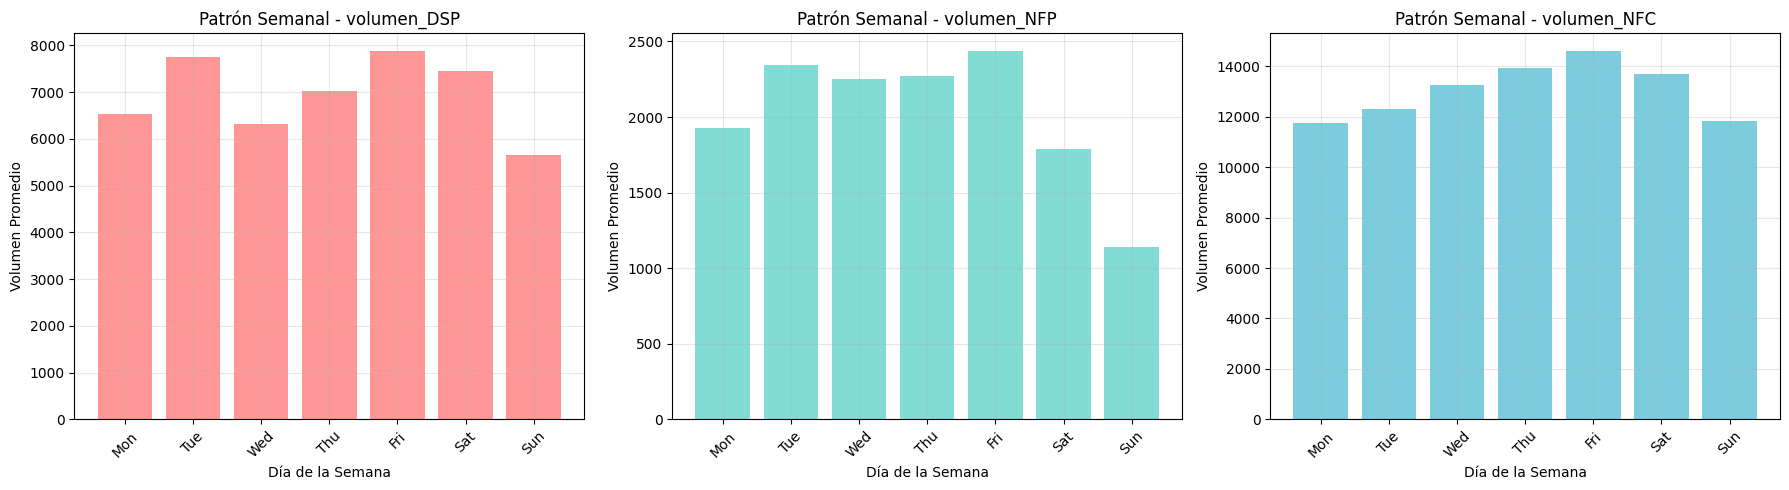

In [ ]:
# --- PATRONES ESTACIONALES ---

# Agregar columnas temporales
merged_df_temp = merged_df_completo.copy()
merged_df_temp['year'] = merged_df_temp.index.year
merged_df_temp['month'] = merged_df_temp.index.month
merged_df_temp['quarter'] = merged_df_temp.index.quarter
merged_df_temp['weekday'] = merged_df_temp.index.day_name()
merged_df_temp['day_of_year'] = merged_df_temp.index.dayofyear

# Patrones por mes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, var in enumerate(variables):
    monthly_data = merged_df_temp.groupby('month')[var].agg(['mean', 'std', 'median'])

    axes[i].bar(monthly_data.index, monthly_data['mean'],
               alpha=0.7, color=colors[i], label='Promedio')
    axes[i].errorbar(monthly_data.index, monthly_data['mean'],
                    yerr=monthly_data['std'], fmt='none', color='black', alpha=0.5)
    axes[i].set_title(f'Patrón Mensual - {var}')
    axes[i].set_xlabel('Mes')
    axes[i].set_ylabel('Volumen Promedio')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Patrones por día de la semana
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, var in enumerate(variables):
    weekday_data = merged_df_temp.groupby('weekday')[var].mean().reindex(weekday_order)

    axes[i].bar(range(len(weekday_data)), weekday_data.values,
               alpha=0.7, color=colors[i])
    axes[i].set_title(f'Patrón Semanal - {var}')
    axes[i].set_xlabel('Día de la Semana')
    axes[i].set_ylabel('Volumen Promedio')
    axes[i].set_xticks(range(len(weekday_order)))
    axes[i].set_xticklabels([day[:3] for day in weekday_order], rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



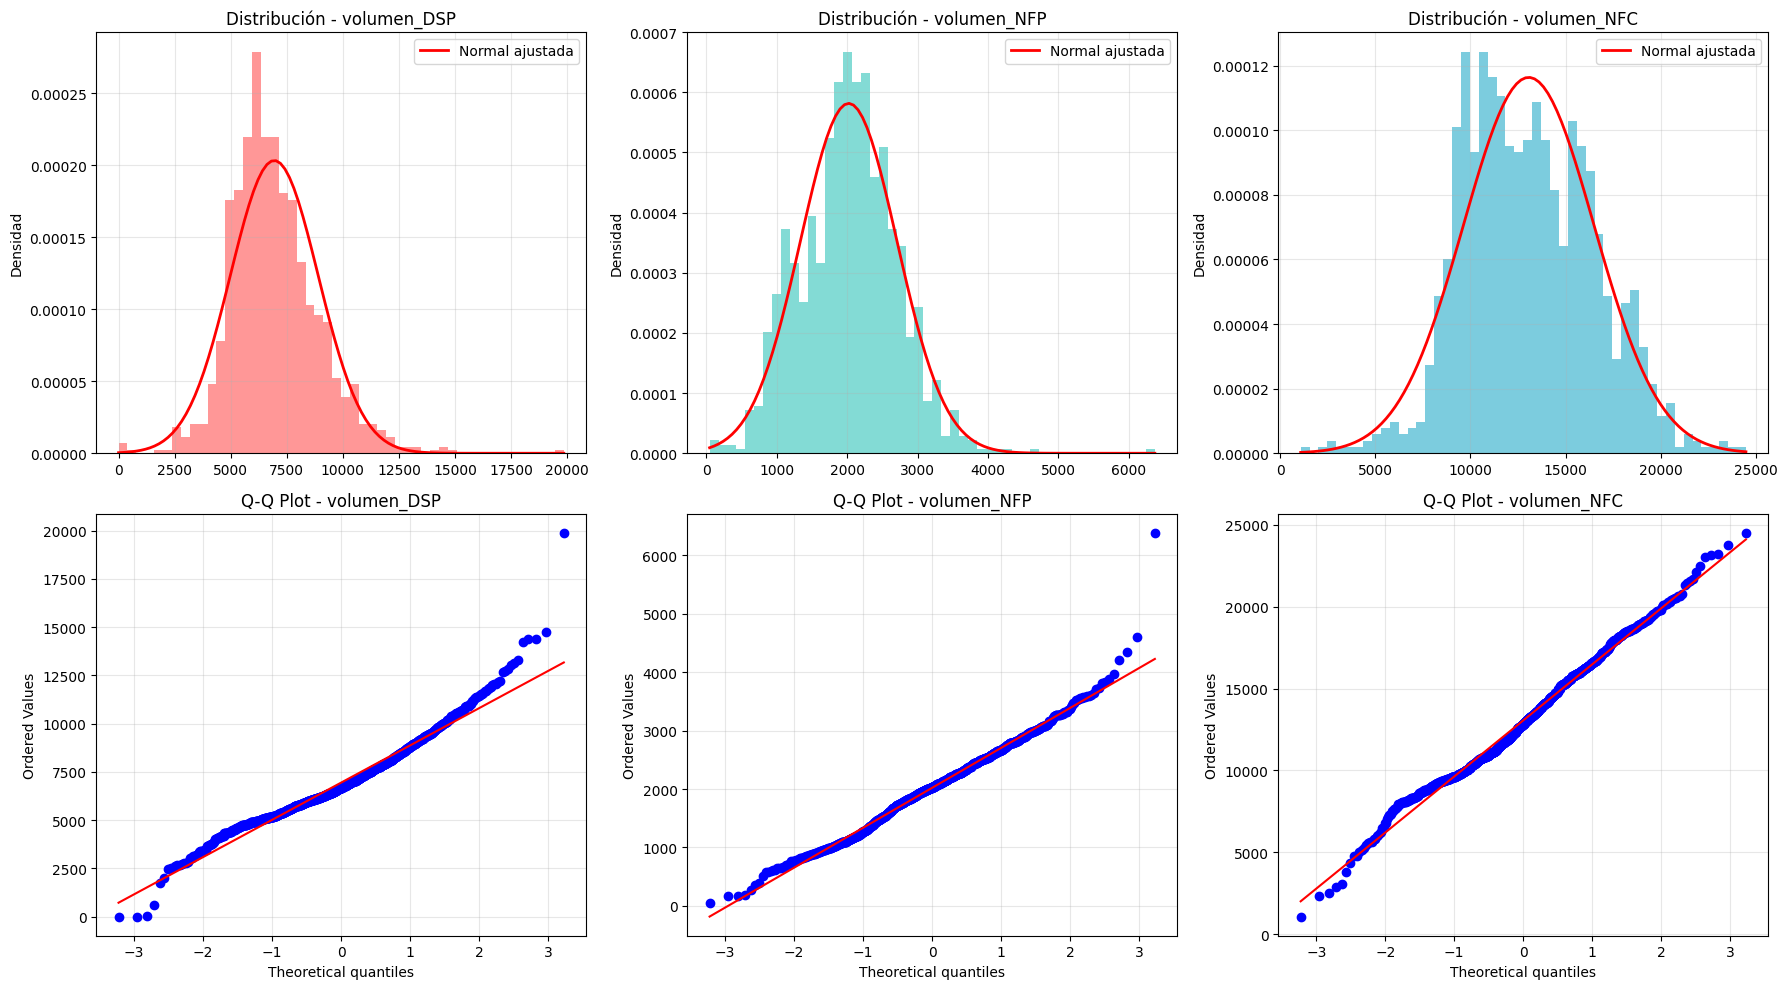


TESTS DE NORMALIDAD:

volumen_DSP:
  Shapiro-Wilk: estadístico=0.9650, p-valor=1.2323e-15
  Kolmogorov-Smirnov: estadístico=0.0638, p-valor=2.4522e-04
  Interpretación: No normal (α=0.05)

volumen_NFP:
  Shapiro-Wilk: estadístico=0.9877, p-valor=5.5164e-08
  Kolmogorov-Smirnov: estadístico=0.0269, p-valor=3.9550e-01
  Interpretación: Normal (α=0.05)

volumen_NFC:
  Shapiro-Wilk: estadístico=0.9915, p-valor=5.3680e-06
  Kolmogorov-Smirnov: estadístico=0.0501, p-valor=7.5685e-03
  Interpretación: No normal (α=0.05)


In [ ]:
# --- DISTRIBUCIONES Y NORMALIDAD ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(variables):
    data = merged_df_completo[var].dropna()

    # Histograma con distribución normal superpuesta
    axes[0,i].hist(data, bins=50, alpha=0.7, density=True, color=colors[i])

    # Ajustar distribución normal
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    axes[0,i].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal ajustada')
    axes[0,i].set_title(f'Distribución - {var}')
    axes[0,i].set_ylabel('Densidad')
    axes[0,i].legend()
    axes[0,i].grid(True, alpha=0.3)

    # Q-Q plot para normalidad
    stats.probplot(data, dist="norm", plot=axes[1,i])
    axes[1,i].set_title(f'Q-Q Plot - {var}')
    axes[1,i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tests de normalidad
print("\nTESTS DE NORMALIDAD:")
for var in variables:
    data = merged_df_completo[var].dropna()

    # Shapiro-Wilk (para muestras pequeñas)
    if len(data) <= 5000:
        shapiro_stat, shapiro_p = stats.shapiro(data.sample(5000) if len(data) > 5000 else data)
        print(f"\n{var}:")
        print(f"  Shapiro-Wilk: estadístico={shapiro_stat:.4f}, p-valor={shapiro_p:.4e}")

    # Kolmogorov-Smirnov
    ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"  Kolmogorov-Smirnov: estadístico={ks_stat:.4f}, p-valor={ks_p:.4e}")

    print(f"  Interpretación: {'Normal' if ks_p > 0.05 else 'No normal'} (α=0.05)")




volumen_DSP:
  Pendiente: -0.4006 (cambio por día)
  R-cuadrado: 0.0042
  P-valor: 3.1001e-02
  Tendencia: Decreciente

volumen_NFP:
  Pendiente: -0.0537 (cambio por día)
  R-cuadrado: 0.0006
  P-valor: 4.0892e-01
  Tendencia: Decreciente

volumen_NFC:
  Pendiente: 5.7920 (cambio por día)
  R-cuadrado: 0.2887
  P-valor: 1.9394e-83
  Tendencia: Creciente


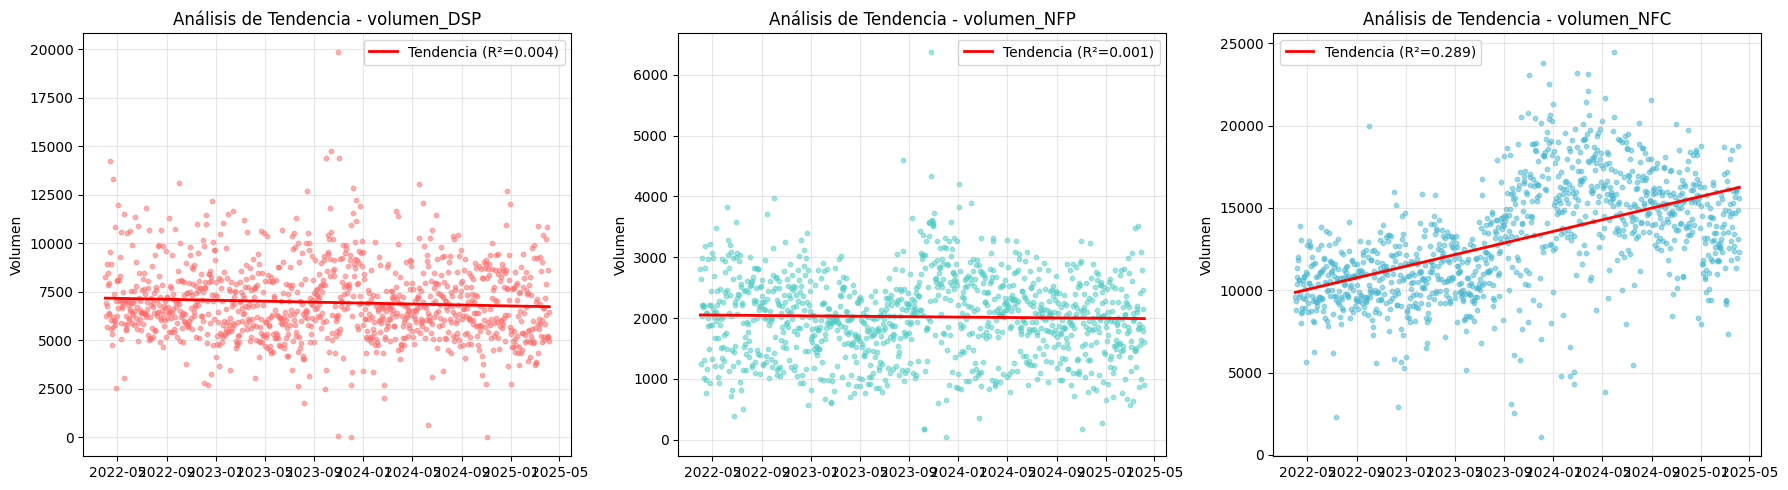

In [ ]:
# --- ANÁLISIS DE TENDENCIAS ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, var in enumerate(variables):
    data = merged_df_completo[var].dropna()
    dates = merged_df_completo[var].dropna().index

    # Convertir fechas a números para regresión
    dates_numeric = (dates - dates.min()).days

    # Regresión lineal
    slope, intercept, r_value, p_value, std_err = stats.linregress(dates_numeric, data)
    trend_line = slope * dates_numeric + intercept

    # Gráfico
    axes[i].scatter(dates, data, alpha=0.5, s=10, color=colors[i])
    axes[i].plot(dates, trend_line, 'r-', linewidth=2,
                label=f'Tendencia (R²={r_value**2:.3f})')
    axes[i].set_title(f'Análisis de Tendencia - {var}')
    axes[i].set_ylabel('Volumen')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

    print(f"\n{var}:")
    print(f"  Pendiente: {slope:.4f} (cambio por día)")
    print(f"  R-cuadrado: {r_value**2:.4f}")
    print(f"  P-valor: {p_value:.4e}")
    print(f"  Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")

plt.tight_layout()
plt.show()



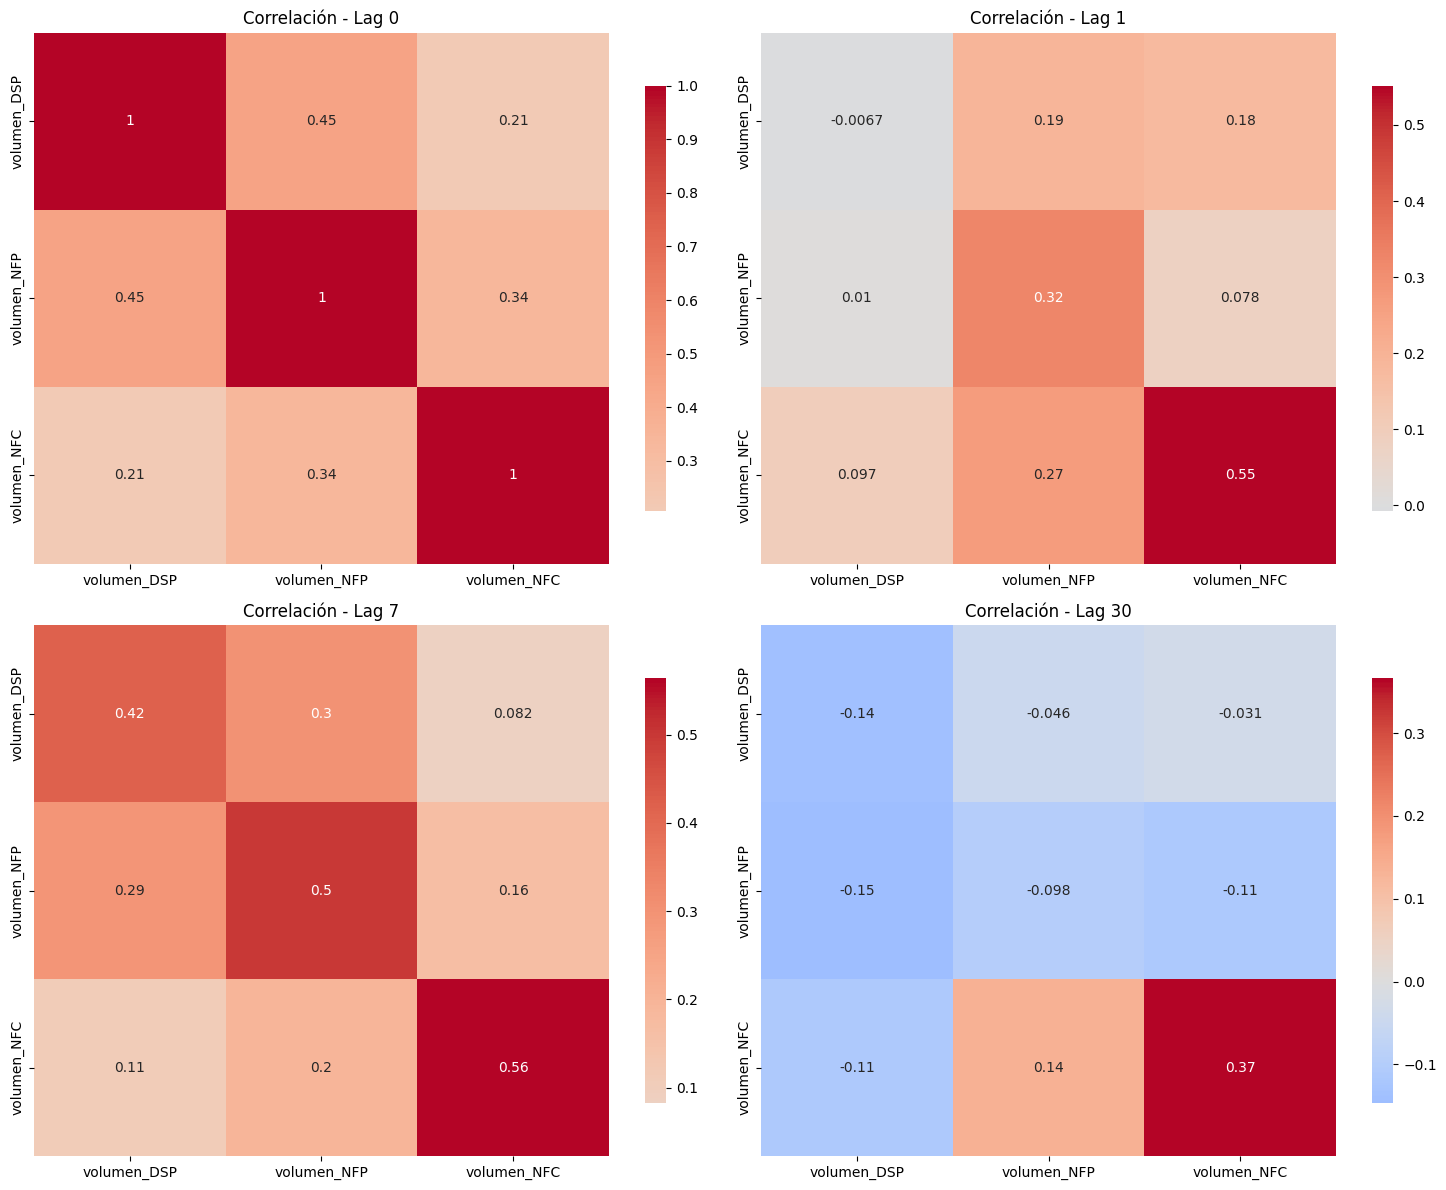

In [ ]:
# --- MATRIZ DE CORRELACIÓN AVANZADA ---
# Correlación con diferentes lags
correlation_results = {}
for lag in [0, 1, 7, 30]:  # Sin lag, 1 día, 1 semana, 1 mes
    corr_matrix = pd.DataFrame()
    for var1 in variables:
        for var2 in variables:
            if lag == 0:
                corr = merged_df_completo[var1].corr(merged_df_completo[var2])
            else:
                corr = merged_df_completo[var1].corr(merged_df_completo[var2].shift(lag))
            corr_matrix.loc[var1, var2] = corr
    correlation_results[f'Lag_{lag}'] = corr_matrix

# Visualizar correlaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (lag_name, corr_matrix) in enumerate(correlation_results.items()):
    sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm',
               center=0, ax=axes[i], cbar_kws={'shrink': 0.8})
    axes[i].set_title(f'Correlación - {lag_name.replace("_", " ")}')

plt.tight_layout()
plt.show()




volumen_DSP - Estadísticas de Volatilidad:
  Volatilidad promedio: 20.8015
  Volatilidad máxima: 446.0484
  Volatilidad mínima: 3.0021

volumen_NFP - Estadísticas de Volatilidad:
  Volatilidad promedio: 10.7675
  Volatilidad máxima: 41.4956
  Volatilidad mínima: 4.3991

volumen_NFC - Estadísticas de Volatilidad:
  Volatilidad promedio: 5.2903
  Volatilidad máxima: 17.9056
  Volatilidad mínima: 1.8567


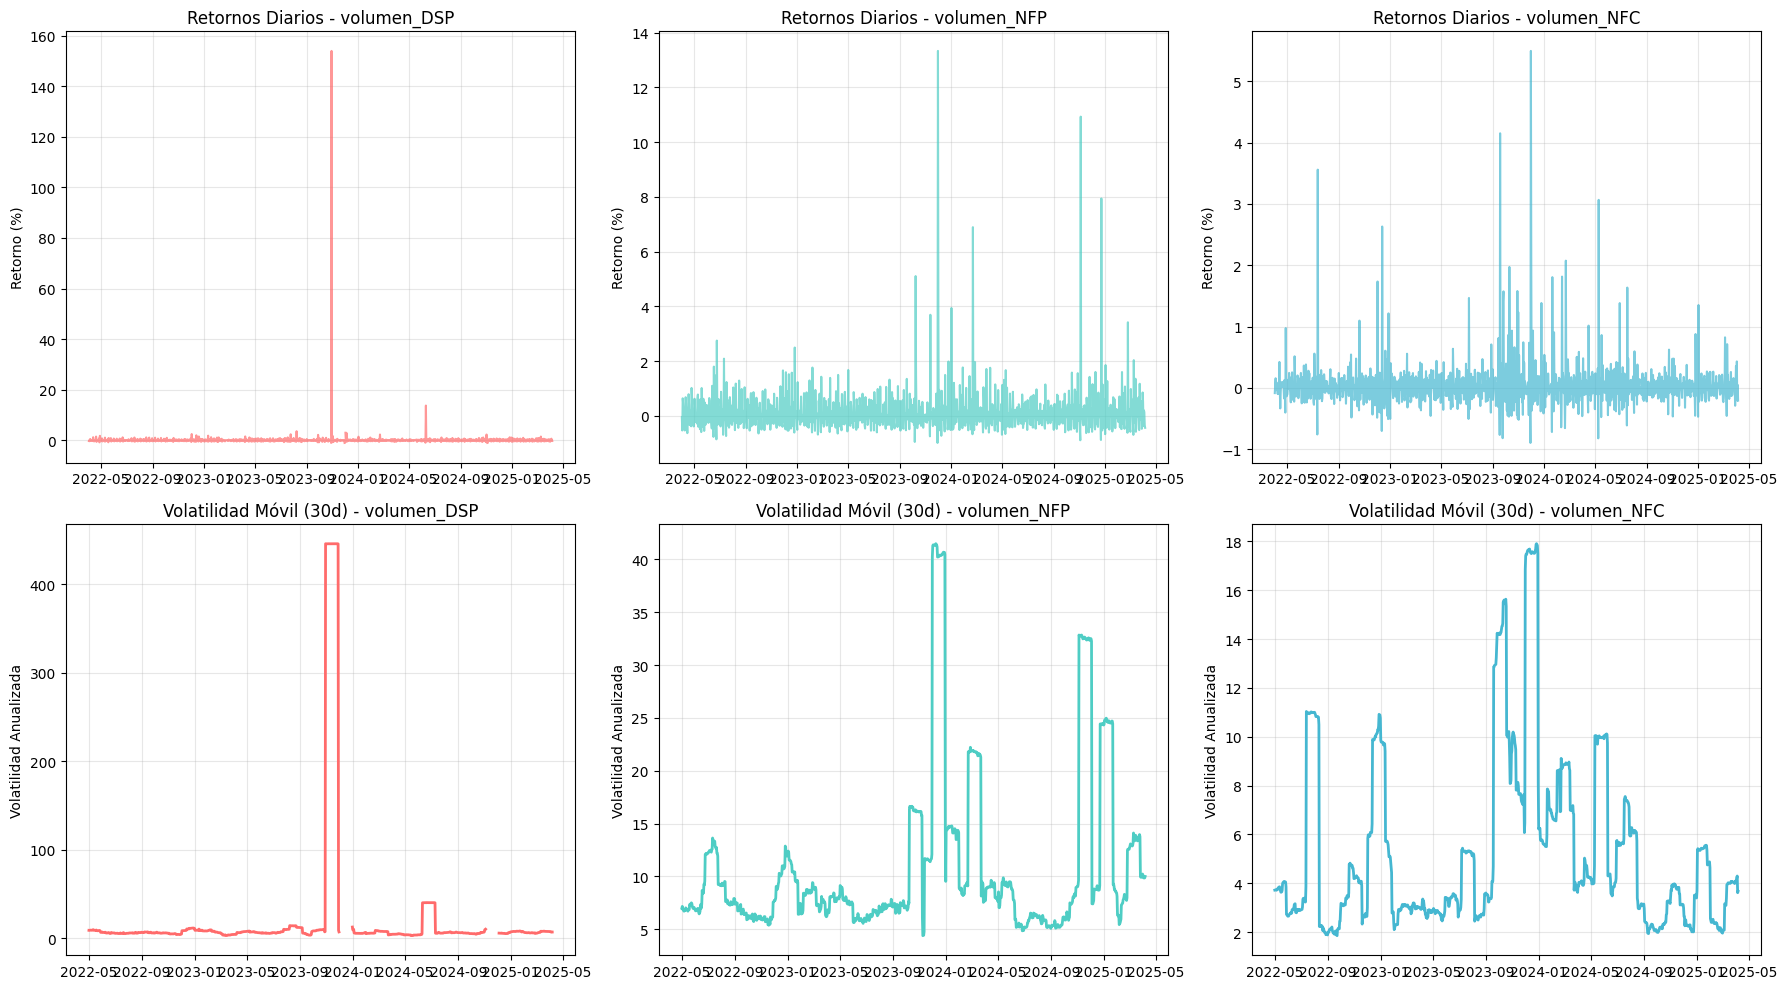

In [ ]:
# --- ANÁLISIS DE VOLATILIDAD ---

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(variables):
    data = merged_df_completo[var].dropna()

    # Retornos diarios (cambio porcentual)
    returns = data.pct_change().dropna()

    # Volatilidad móvil (desviación estándar de retornos en ventana de 30 días)
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # Anualizada

    # Gráfico de retornos
    axes[0,i].plot(returns.index, returns, alpha=0.7, color=colors[i])
    axes[0,i].set_title(f'Retornos Diarios - {var}')
    axes[0,i].set_ylabel('Retorno (%)')
    axes[0,i].grid(True, alpha=0.3)

    # Gráfico de volatilidad
    axes[1,i].plot(rolling_vol.index, rolling_vol, color=colors[i], linewidth=2)
    axes[1,i].set_title(f'Volatilidad Móvil (30d) - {var}')
    axes[1,i].set_ylabel('Volatilidad Anualizada')
    axes[1,i].grid(True, alpha=0.3)

    print(f"\n{var} - Estadísticas de Volatilidad:")
    print(f"  Volatilidad promedio: {rolling_vol.mean():.4f}")
    print(f"  Volatilidad máxima: {rolling_vol.max():.4f}")
    print(f"  Volatilidad mínima: {rolling_vol.min():.4f}")

plt.tight_layout()
plt.show()



In [ ]:
# --- ANÁLISIS DE VALORES EXTREMOS POR PERÍODO ---
print("\n7. ANÁLISIS DE VALORES EXTREMOS POR PERÍODO")
print("-"*50)

for var in variables:
    print(f"\n{var}:")
    data_with_date = merged_df_completo[var].dropna()

    # Top 10 valores más altos
    top_10 = data_with_date.nlargest(10)
    print("  Top 10 valores más altos:")
    for date, value in top_10.items():
        print(f"    {date.strftime('%Y-%m-%d')}: {value:,.2f}")

    # Top 10 valores más bajos
    bottom_10 = data_with_date.nsmallest(10)
    print("  Top 10 valores más bajos:")
    for date, value in bottom_10.items():
        print(f"    {date.strftime('%Y-%m-%d')}: {value:,.2f}")




7. ANÁLISIS DE VALORES EXTREMOS POR PERÍODO
--------------------------------------------------

volumen_DSP:
  Top 10 valores más altos:
    2023-10-31: 19,848.62
    2023-10-13: 14,751.86
    2023-09-29: 14,391.90
    2023-11-02: 14,362.19
    2022-04-12: 14,224.54
    2022-04-19: 13,297.83
    2022-09-30: 13,112.11
    2024-05-19: 13,048.34
    2023-12-05: 12,834.16
    2024-12-23: 12,699.82
  Top 10 valores más bajos:
    2023-11-30: 0.00
    2024-11-03: 0.00
    2023-10-29: 40.51
    2024-06-09: 596.66
    2023-08-07: 1,759.10
    2024-02-21: 2,001.43
    2023-09-27: 2,458.26
    2022-04-27: 2,503.45
    2023-07-24: 2,640.27
    2022-12-12: 2,657.24

volumen_NFP:
  Top 10 valores más altos:
    2023-10-26: 6,371.38
    2023-08-16: 4,600.33
    2023-10-25: 4,339.03
    2024-01-02: 4,198.90
    2022-09-30: 3,973.79
    2024-01-31: 3,887.45
    2022-06-07: 3,830.07
    2024-01-03: 3,818.76
    2023-11-01: 3,726.75
    2022-09-13: 3,713.93
  Top 10 valores más bajos:
    2023-11-30: 4

In [ ]:
# --- RESUMEN ---
print("\n" + "="*80)
print("RESUMEN")
print("="*80)

for var in variables:
    data = merged_df_completo[var].dropna()
    print(f"\n{var}:")
    print(f"  • Rango temporal: {data.index.min().strftime('%Y-%m-%d')} a {data.index.max().strftime('%Y-%m-%d')}")
    print(f"  • Observaciones: {len(data):,}")
    print(f"  • Promedio: {data.mean():,.2f}")
    print(f"  • Mediana: {data.median():,.2f}")
    print(f"  • Desviación estándar: {data.std():,.2f}")
    print(f"  • Coeficiente de variación: {(data.std()/data.mean())*100:.2f}%")
    print(f"  • Asimetría: {data.skew():.3f}")
    print(f"  • Curtosis: {data.kurtosis():.3f}")

    # Tendencia
    dates_numeric = (data.index - data.index.min()).days
    slope, _, r_value, p_value, _ = stats.linregress(dates_numeric, data)
    trend = "Creciente" if slope > 0 else "Decreciente"
    print(f"  • Tendencia: {trend} (R²={r_value**2:.3f})")

print(f"\nCorrelaciones más fuertes:")
corr_matrix = merged_df_completo[variables].corr()
# Obtener correlaciones sin la diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_values = corr_matrix.mask(mask).stack().abs().sort_values(ascending=False)
for pair, corr in corr_values.head(3).items():
    print(f"  • {pair[0]} vs {pair[1]}: {corr:.3f}")

print("\n" + "="*80)


RESUMEN

volumen_DSP:
  • Rango temporal: 2022-04-01 a 2025-04-06
  • Observaciones: 1,102
  • Promedio: 6,941.43
  • Mediana: 6,667.53
  • Desviación estándar: 1,961.89
  • Coeficiente de variación: 28.26%
  • Asimetría: 0.721
  • Curtosis: 2.572
  • Tendencia: Decreciente (R²=0.004)

volumen_NFP:
  • Rango temporal: 2022-04-01 a 2025-04-06
  • Observaciones: 1,102
  • Promedio: 2,021.70
  • Mediana: 2,029.72
  • Desviación estándar: 686.33
  • Coeficiente de variación: 33.95%
  • Asimetría: 0.291
  • Curtosis: 1.282
  • Tendencia: Decreciente (R²=0.001)

volumen_NFC:
  • Rango temporal: 2022-04-01 a 2025-04-06
  • Observaciones: 1,102
  • Promedio: 13,057.39
  • Mediana: 12,831.34
  • Desviación estándar: 3,430.94
  • Coeficiente de variación: 26.28%
  • Asimetría: 0.162
  • Curtosis: -0.034
  • Tendencia: Creciente (R²=0.289)

Correlaciones más fuertes:
  • volumen_NFP vs volumen_DSP: 0.447
  • volumen_NFC vs volumen_NFP: 0.342
  • volumen_NFC vs volumen_DSP: 0.207



TRATAMIENTO DE OUTLIERS

In [ ]:
# Configurar estilo de los gráficos
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# --- APLICAR REEMPLAZO DE OUTLIERS ---
print("="*80)
print("REEMPLAZO DE OUTLIERS")
print("="*80)

# Crear una copia del dataframe original
merged_df_original = merged_df_completo.copy()
merged_df_clean = merged_df_completo.copy()

# Método a usar (puedes cambiar este valor)
outlier_method = 'winsorize'  # Opciones: 'winsorize', 'cap', 'median', 'mean', 'remove'

outlier_summary = []

for col in ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']:
    print(f"\nProcesando {col}...")

    # Aplicar reemplazo de outliers
    clean_data, info = replace_outliers(merged_df_clean[col].dropna(), method=outlier_method)

    # Actualizar el dataframe
    merged_df_clean[col] = clean_data

    # Guardar información
    info['variable'] = col
    outlier_summary.append(info)

    print(f"  Outliers originales: {info['original_outliers']} ({info['outlier_percentage']:.1f}%)")
    print(f"  Método usado: {info['method_used']}")

REEMPLAZO DE OUTLIERS

Procesando volumen_DSP...
  Outliers originales: 31 (2.8%)
  Método usado: winsorize

Procesando volumen_NFP...
  Outliers originales: 7 (0.6%)
  Método usado: winsorize

Procesando volumen_NFC...
  Outliers originales: 8 (0.7%)
  Método usado: winsorize


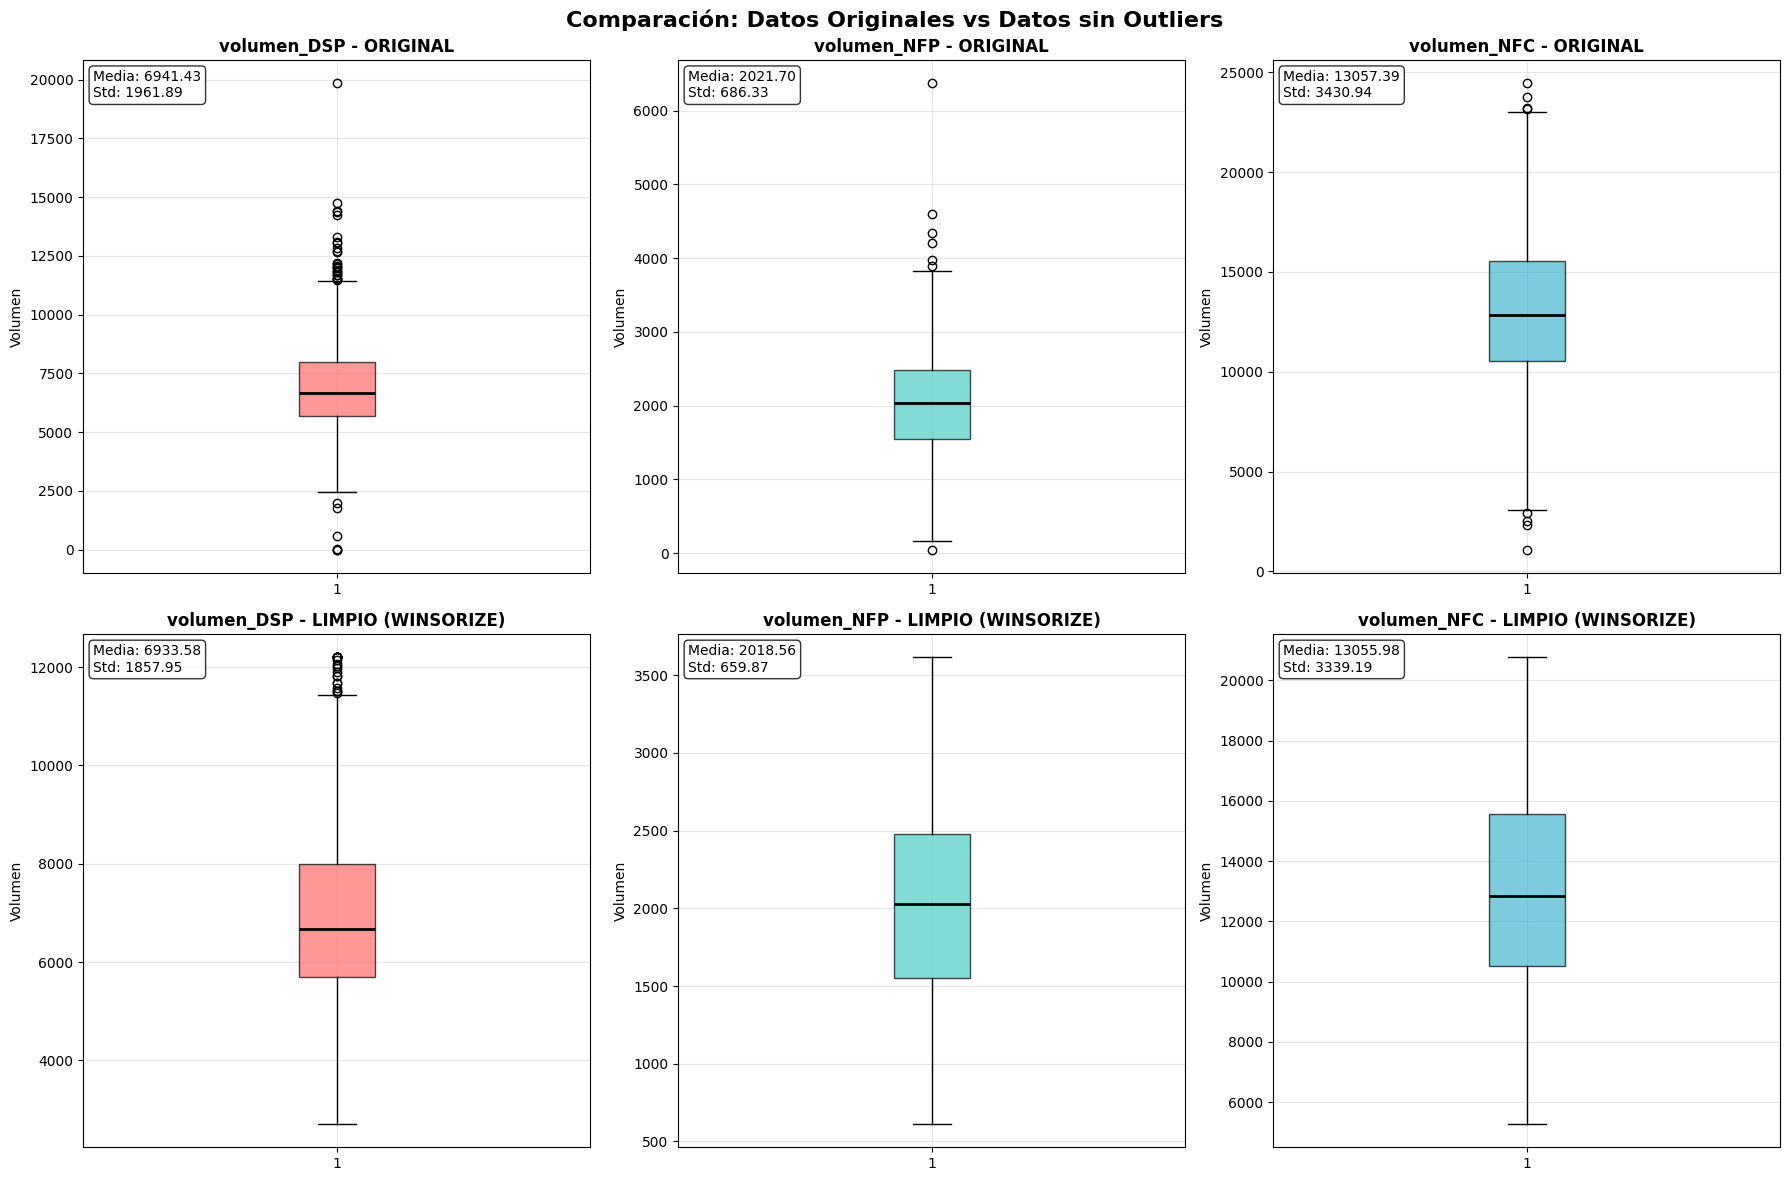

In [ ]:
# --- COMPARACIÓN ANTES/DESPUÉS ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación: Datos Originales vs Datos sin Outliers', fontsize=16, fontweight='bold')

variables = ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (var, color) in enumerate(zip(variables, colores)):
    # Boxplot datos originales
    axes[0, i].boxplot(merged_df_original[var].dropna(),
                      patch_artist=True,
                      boxprops=dict(facecolor=color, alpha=0.7),
                      medianprops=dict(color='black', linewidth=2))
    axes[0, i].set_title(f'{var} - ORIGINAL', fontweight='bold')
    axes[0, i].set_ylabel('Volumen')
    axes[0, i].grid(True, alpha=0.3)

    # Boxplot datos limpios
    axes[1, i].boxplot(merged_df_clean[var].dropna(),
                      patch_artist=True,
                      boxprops=dict(facecolor=color, alpha=0.7),
                      medianprops=dict(color='black', linewidth=2))
    axes[1, i].set_title(f'{var} - LIMPIO ({outlier_method.upper()})', fontweight='bold')
    axes[1, i].set_ylabel('Volumen')
    axes[1, i].grid(True, alpha=0.3)

    # Estadísticas
    original_stats = f'Media: {merged_df_original[var].mean():.2f}\nStd: {merged_df_original[var].std():.2f}'
    clean_stats = f'Media: {merged_df_clean[var].mean():.2f}\nStd: {merged_df_clean[var].std():.2f}'

    axes[0, i].text(0.02, 0.98, original_stats, transform=axes[0, i].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[1, i].text(0.02, 0.98, clean_stats, transform=axes[1, i].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

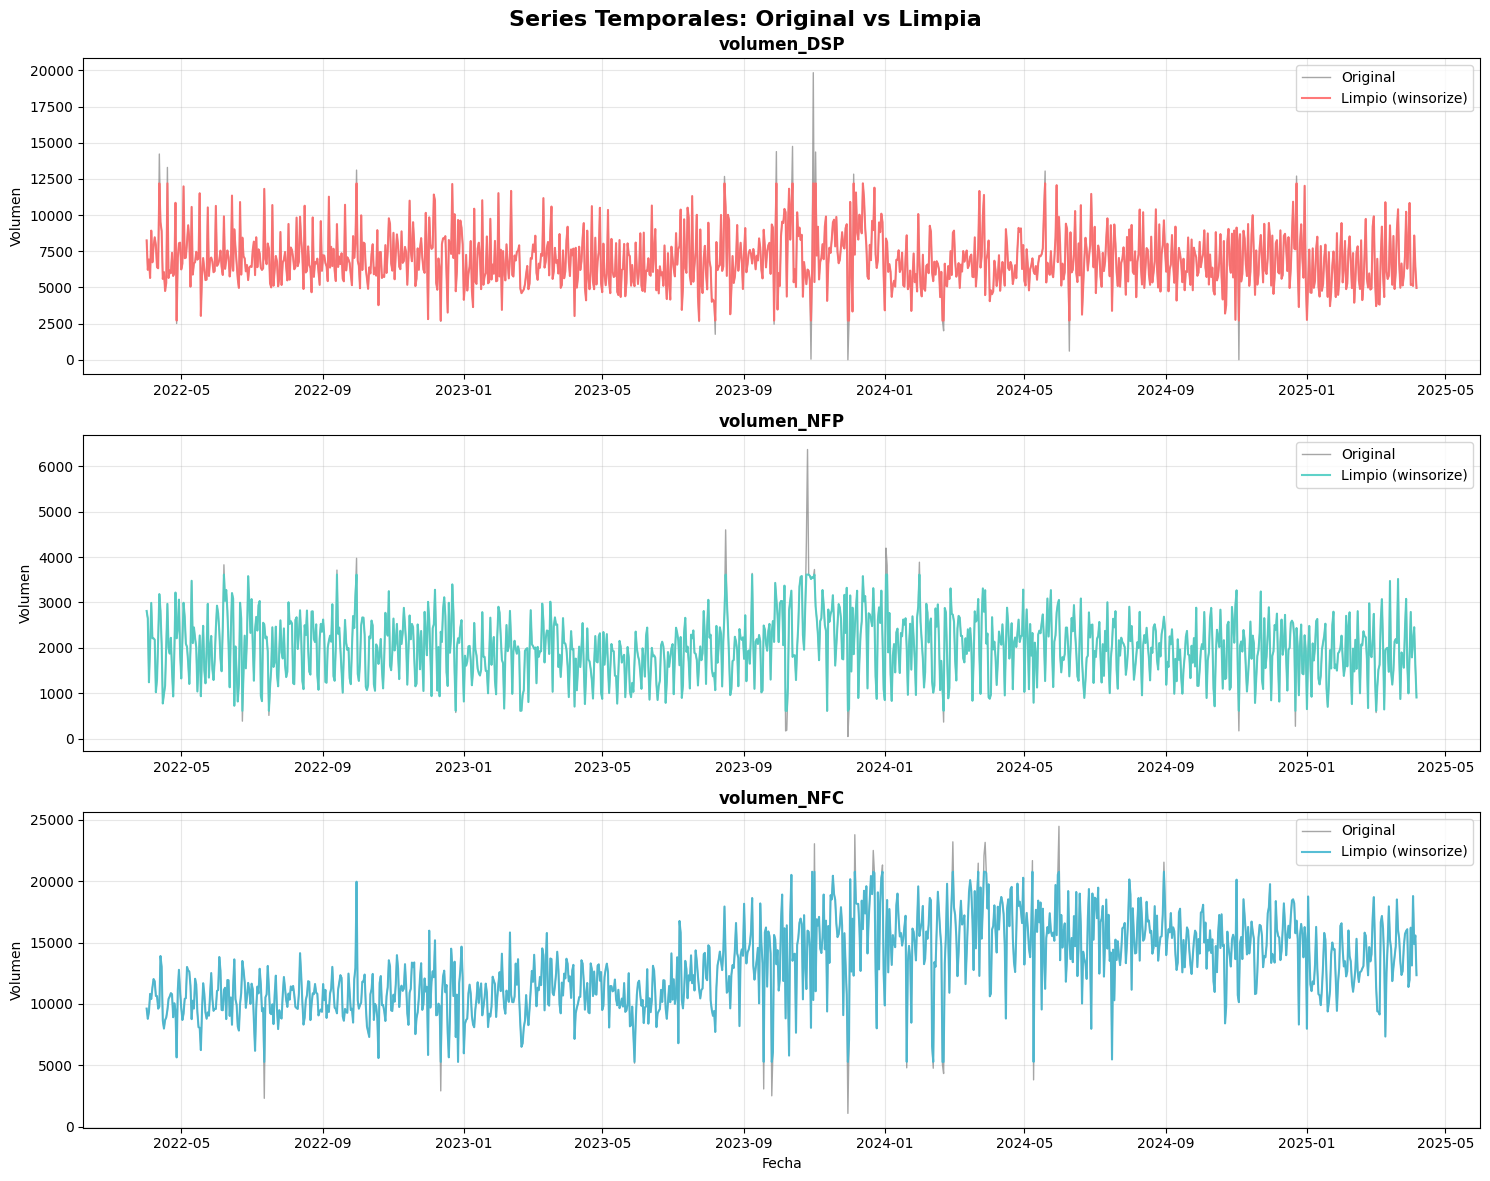

In [ ]:
# --- SERIES TEMPORALES COMPARATIVAS ---
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Series Temporales: Original vs Limpia', fontsize=16, fontweight='bold')

for i, (var, color) in enumerate(zip(variables, colores)):
    axes[i].plot(merged_df_original.index, merged_df_original[var],
                alpha=0.7, color='gray', label='Original', linewidth=1)
    axes[i].plot(merged_df_clean.index, merged_df_clean[var],
                alpha=0.9, color=color, label=f'Limpio ({outlier_method})', linewidth=1.5)

    axes[i].set_title(f'{var}', fontweight='bold')
    axes[i].set_ylabel('Volumen')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()


In [ ]:
# --- TABLA DE SUMMARY DE OUTLIERS ---
print("\n" + "="*80)
print("RESUMEN DEL TRATAMIENTO DE OUTLIERS")
print("="*80)

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df[['variable', 'original_outliers', 'outlier_percentage', 'method_used']]
outlier_df.columns = ['Variable', 'Outliers_Detectados', 'Porcentaje_%', 'Método_Usado']
outlier_df['Porcentaje_%'] = outlier_df['Porcentaje_%'].round(2)

print(outlier_df.to_string(index=False))

# --- TABLA DE SUMMARY COMPARATIVA ---
print("\n" + "="*80)
print("ESTADÍSTICAS COMPARATIVAS: ORIGINAL vs LIMPIO")
print("="*80)

comparison_stats = []

for col in ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']:
    original_data = merged_df_original[col].dropna()
    clean_data = merged_df_clean[col].dropna()

    stats = {
        'Variable': col,
        'Mean_Original': original_data.mean(),
        'Mean_Clean': clean_data.mean(),
        'Std_Original': original_data.std(),
        'Std_Clean': clean_data.std(),
        'Median_Original': original_data.median(),
        'Median_Clean': clean_data.median(),
        'Min_Original': original_data.min(),
        'Min_Clean': clean_data.min(),
        'Max_Original': original_data.max(),
        'Max_Clean': clean_data.max(),
        'Skew_Original': original_data.skew(),
        'Skew_Clean': clean_data.skew()
    }
    comparison_stats.append(stats)

comparison_df = pd.DataFrame(comparison_stats)

# Formatear números
numeric_cols = [col for col in comparison_df.columns if col != 'Variable']
for col in numeric_cols:
    if 'Skew' in col:
        comparison_df[col] = comparison_df[col].round(3)
    else:
        comparison_df[col] = comparison_df[col].round(2)

print(comparison_df.to_string(index=False))



RESUMEN DEL TRATAMIENTO DE OUTLIERS
   Variable  Outliers_Detectados  Porcentaje_% Método_Usado
volumen_DSP                   31          2.81    winsorize
volumen_NFP                    7          0.64    winsorize
volumen_NFC                    8          0.73    winsorize

ESTADÍSTICAS COMPARATIVAS: ORIGINAL vs LIMPIO
   Variable  Mean_Original  Mean_Clean  Std_Original  Std_Clean  Median_Original  Median_Clean  Min_Original  Min_Clean  Max_Original  Max_Clean  Skew_Original  Skew_Clean
volumen_DSP        6941.43     6933.58       1961.89    1857.95          6667.53       6667.53          0.00    2708.38      19848.62   12196.35          0.721       0.514
volumen_NFP        2021.70     2018.56        686.33     659.87          2029.72       2029.72         45.70     612.60       6371.38    3614.41          0.291       0.041
volumen_NFC       13057.39    13055.98       3430.94    3339.19         12831.34      12831.34       1084.59    5276.96      24462.23   20763.20          0.162 

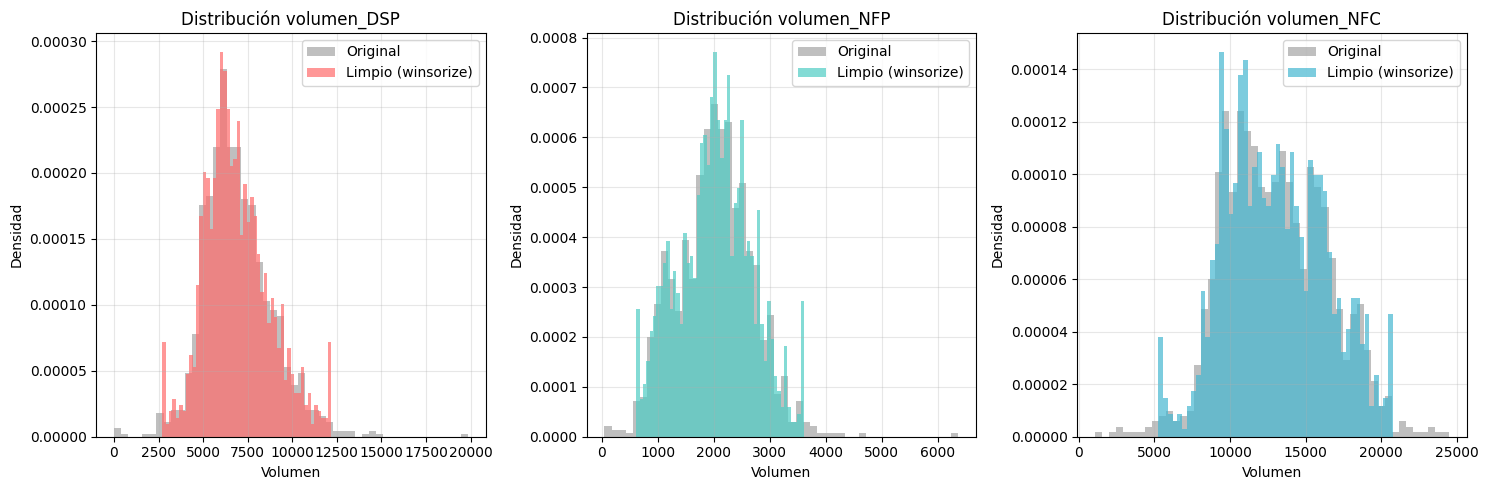

In [ ]:
# --- GRÁFICO DE DISTRIBUCIONES ---
plt.figure(figsize=(15, 5))

for i, var in enumerate(variables, 1):
    plt.subplot(1, 3, i)

    # Histograma datos originales
    plt.hist(merged_df_original[var].dropna(), bins=50, alpha=0.5,
            label='Original', color='gray', density=True)

    # Histograma datos limpios
    plt.hist(merged_df_clean[var].dropna(), bins=50, alpha=0.7,
            label=f'Limpio ({outlier_method})', color=colores[i-1], density=True)

    plt.title(f'Distribución {var}')
    plt.xlabel('Volumen')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# --- MATRIZ DE CORRELACIÓN COMPARATIVA ---
print("\n" + "="*80)
print("MATRICES DE CORRELACIÓN")
print("="*80)

print("ORIGINAL:")
correlation_original = merged_df_original[['volumen_DSP', 'volumen_NFP', 'volumen_NFC']].corr()
print(correlation_original.round(3))

print(f"\nLIMPIO ({outlier_method.upper()}):")
correlation_clean = merged_df_clean[['volumen_DSP', 'volumen_NFP', 'volumen_NFC']].corr()
print(correlation_clean.round(3))

# --- INFORMACIÓN FINAL ---
print("\n" + "="*80)
print("INFORMACIÓN FINAL")
print("="*80)

print(f"Método de reemplazo utilizado: {outlier_method}")
print(f"DataFrame original guardado como: merged_df_original")
print(f"DataFrame limpio guardado como: merged_df_clean")


MATRICES DE CORRELACIÓN
ORIGINAL:
             volumen_DSP  volumen_NFP  volumen_NFC
volumen_DSP        1.000        0.447        0.207
volumen_NFP        0.447        1.000        0.342
volumen_NFC        0.207        0.342        1.000

LIMPIO (WINSORIZE):
             volumen_DSP  volumen_NFP  volumen_NFC
volumen_DSP        1.000        0.462        0.215
volumen_NFP        0.462        1.000        0.346
volumen_NFC        0.215        0.346        1.000

INFORMACIÓN FINAL
Método de reemplazo utilizado: winsorize
DataFrame original guardado como: merged_df_original
DataFrame limpio guardado como: merged_df_clean


In [ ]:
# Ejemplo de uso de la función comparativa
print("\n" + "="*80)
print("COMPARACIÓN DE MÉTODOS DE OUTLIERS")
print("="*80)

# Puedes descomentar estas líneas para ver comparación de métodos
for col in ['volumen_DSP', 'volumen_NFP', 'volumen_NFC']:
    compare_outlier_methods(merged_df_original, col)


COMPARACIÓN DE MÉTODOS DE OUTLIERS

Comparación de métodos para volumen_DSP:
--------------------------------------------------
 winsorize: Mean=6933.58, Std=1857.95, Skew= 0.514, Outliers=31
       cap: Mean=6918.42, Std=1833.00, Skew= 0.392, Outliers=31
    median: Mean=6834.05, Std=1664.70, Skew= 0.338, Outliers=31
      mean: Mean=6841.75, Std=1664.54, Skew= 0.324, Outliers=31

Comparación de métodos para volumen_NFP:
--------------------------------------------------
 winsorize: Mean=2018.56, Std= 659.87, Skew= 0.041, Outliers=7
       cap: Mean=2018.03, Std= 670.99, Skew= 0.036, Outliers=7
    median: Mean=2009.71, Std= 654.47, Skew=-0.026, Outliers=7
      mean: Mean=2009.66, Std= 654.46, Skew=-0.026, Outliers=7

Comparación de métodos para volumen_NFC:
--------------------------------------------------
 winsorize: Mean=13055.98, Std=3339.19, Skew= 0.173, Outliers=8
       cap: Mean=13058.20, Std=3415.82, Skew= 0.171, Outliers=8
    median: Mean=13056.70, Std=3306.63, Skew= 0.1

In [ ]:
# Define the path to save the file in Google Drive
save_path = '/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv'

# Save the dataframe to CSV
try:
    merged_df_clean.to_csv(save_path)
    print(f"DataFrame successfully saved to {save_path}")
except Exception as e:
    print(f"An error occurred while saving the DataFrame: {e}")

DataFrame successfully saved to /content/drive/MyDrive/Datos_EESS/merged_df_clean.csv
